# Lorenz-63 のパラメータ推定を Kalman Filter で行う３

0109の発表用


In [1]:
import numpy as np
import matplotlib.pyplot as plt
lfontsize = 14

import seaborn as sns

print(f"numpy version: {np.__version__}")

numpy version: 1.23.2


In [2]:
def L63_explicit(X: np.ndarray, t: float) -> np.ndarray:
    """
    L63 model with explicit time stepping
    input: 
        t = time
        X = [x, y, z, sigma, rho, beta]
    output: dX/dt
    """
    x, y, z = X[0:3]
    s, r, b = X[3:6]
    dx = s * (y - x)
    dy = x * (r - z) - y
    dz = x * y - b * z
    ds = 0
    dr = 0
    db = 0
    return np.array([dx, dy, dz, ds, dr, db])

In [3]:
def rk4_step(X: np.ndarray, t: float, Func, Dt: float=0.05):
    k_weight = np.zeros((4, X.shape[0]))

    k_weight[0, :] = K1 = Func(X, t)
    k_weight[1, :] = K2 = Func(X + K1 * Dt / 2, t + Dt / 2)
    k_weight[2, :] = K3 = Func(X + K2 * Dt / 2, t + Dt / 2)
    k_weight[3, :] = K4 = Func(X + K3 * Dt,     t + Dt)

    DX = (K1 + 2 * K2 + 2 * K3 + K4) * Dt / 6
    return DX, k_weight

In [4]:
def Model(Xi: np.ndarray, ti: float, Dt: float=0.05, return_k_weight: bool=False):
    DX, k_weight = rk4_step(Xi, ti, L63_explicit, Dt=Dt)
    if return_k_weight:
        return Xi + DX, k_weight
    else:
        return Xi + DX

In [5]:
nX, k_weight = Model(np.array([1, 1, 1, 10, 28, 8/3]), 0, return_k_weight=True)

print(f"nX: {nX}")
print(f"k_weight: \n {k_weight}")

nX: [ 1.29144907  2.39393332  0.96345562 10.         28.          2.66666667]
k_weight: 
 [[ 0.         26.         -1.66666667  0.          0.          0.        ]
 [ 6.5        25.39166667 -0.90555556  0.          0.          0.        ]
 [ 4.72291667 29.77902604 -0.70585098  0.          0.          0.        ]
 [12.52805469 30.93061294  0.50415358  0.          0.          0.        ]]


In [6]:
def get_tlm_by_approx(X: np.ndarray, t: float, Model, delta: float=0.001):
    J = X.shape[0]
    M = np.zeros((J, J))
    for j in range(J):
        ej = np.zeros(J)
        ej[j] = 1

        M_col_j = (Model(X + delta * ej, t) - Model(X, t)) / delta

        M[:, j] = M_col_j

    return M

In [7]:
M = get_tlm_by_approx(np.array([1, 1, 1, 10, 28, 8/3]), 0, Model)
print(f"M: \n {M}")

M: 
 [[ 8.67588136e-01  4.23326046e-01 -1.13723642e-02  2.69752833e-02
   1.18751924e-02  1.83493067e-04]
 [ 1.14225725e+00  1.24737558e+00 -5.44001089e-02  1.06115114e-02
   5.81346657e-02  1.37040467e-03]
 [ 1.00031554e-01  7.64853094e-02  8.73406246e-01  9.60670866e-04
   1.85125695e-03 -4.54804485e-02]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00
   0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   1.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  1.00000000e+00]]


In [8]:
def KalmanFilter(X: np.ndarray, t: float, y: np.ndarray, Model, M, H, R, Pa, Q=0):
    # forecast
    X = Model(X, t)
    Pf = M @ Pa @ M.T + Q

    # update
    K = Pf @ H.T @ np.linalg.inv(H @ Pf @ H.T + R)
    nX = X + K @ (y - H @ X)
    nPa = (np.eye(X.shape[0]) - K @ H) @ Pf

    return Pf, nX, nPa

## 前回のあらすじ

Model = RK4(L63)

### 同化するデータの作成

パラメータは、
$\sigma = 10, \ \rho = 28, \ \beta = 8/3$
で時間変化なし。

空間座標 $x, y, z$ については、
最初の 0 ~ 1000点を spin up として捨て、
後ろの 1000 ~ 2000点の 1000個のプロットをアトラクタとして入手。
そこに分散 1 のノイズを載せる。

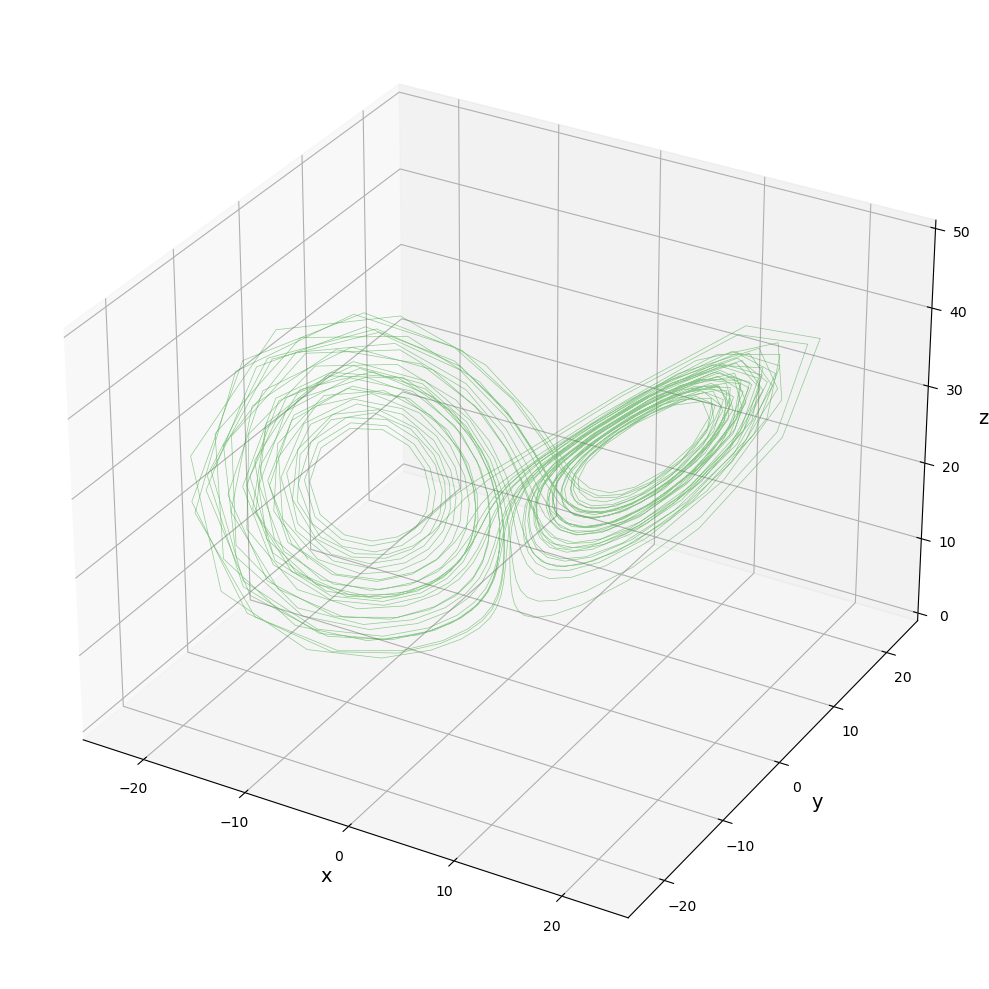

In [9]:
sigma = 10
rho = 28
beta = 8/3
X_init = np.array([1, 1, 1, sigma, rho, beta])

X_list = [X_init]

t_spinup = np.array(range(1000)) * 0.05

for ti in t_spinup:
    X_list.append(Model(X_list[-1], ti))

X_list = [X_list[-1]]

t_integration = np.array(range(1000, 2000)) * 0.05

for ti in t_integration:
    X_list.append(Model(X_list[-1], ti))

X_list.pop(0)
X_attractor= np.array(X_list)

fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection='3d')

ax.plot(X_attractor[:, 0], X_attractor[:, 1], X_attractor[:, 2], lw=0.5, c="C2", alpha=0.5)
ax.set_xlabel("x", fontsize=lfontsize)
ax.set_ylabel("y", fontsize=lfontsize)
ax.set_zlabel("z", fontsize=lfontsize)
ax.set_xlim(-25, 25)
ax.set_ylim(-25, 25)
ax.set_zlim(0, 50)

plt.tight_layout()
plt.savefig("L63_attractor.png", dpi=300)
plt.show()

In [10]:
print(f"X_attractor.shape: {X_attractor.shape}")

X_attractor.shape: (1000, 6)


In [11]:
Y = X_attractor.copy()

for i in range(Y.shape[0]):
    Y[i, 0:3] += np.random.normal(0, 1, 3)

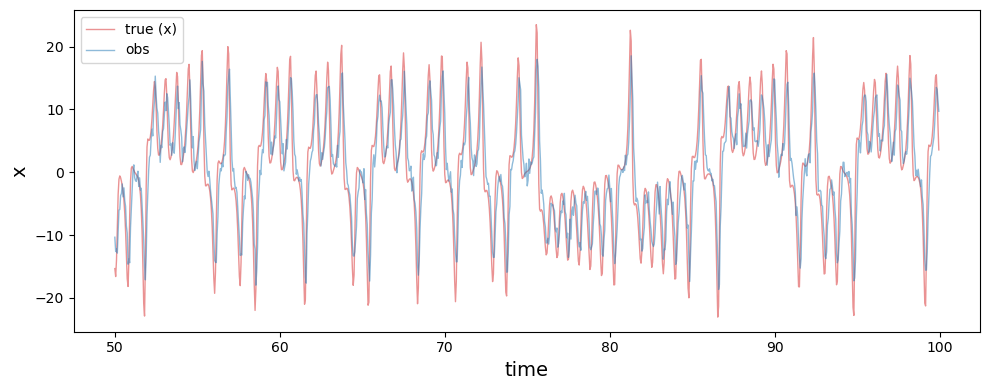

In [12]:
fig, ax = plt.subplots(1, 1, figsize=(10, 4))

ax.plot(t_integration, X_attractor[:, 1], lw=1.0, c="C3", alpha=0.5, label="true (x)")
ax.plot(t_integration, Y[:, 0],           lw=1.0, c="C0", alpha=0.5, label="obs")

ax.set_xlabel("time", fontsize=lfontsize)
ax.set_ylabel("x"   , fontsize=lfontsize)

ax.legend()
plt.tight_layout()
plt.savefig("L63_obs.png", dpi=300)
plt.show()

In [13]:
name_list = ["x", "y", "z", "sigma", "rho", "beta"]

def plot_result_xyz(idx, t_plot, t_integration, assim_X, assim_Pa, estim_Pf, Y, X_attractor):
    fig, ax = plt.subplots(2, 1, figsize=(10, 8), sharex=True)

    obs_rmses, assim_rmses, trPa_xyz, trPf_xyz = [], [], [], []
    for i in range(len(t_integration)):
        obs_rmses  .append(np.sqrt(np.mean((Y[i, :]     [0:3] - X_attractor[i, :][0:3])**2)))
        assim_rmses.append(np.sqrt(np.mean((assim_X[i+1][0:3] - X_attractor[i, :][0:3])**2)))
        
        trPf_xyz.append(np.trace(estim_Pf[i+1][0:3, 0:3]))
    
    for i in range(len(t_plot)):
        trPa_xyz.append(np.trace(assim_Pa[i+1][0:3, 0:3]))
    
    ax[0].plot(t_integration, obs_rmses,   lw=0.5, c="C0", alpha=0.5, label="obs rmse XYZ")
    ax[0].plot(t_integration, assim_rmses, lw=1.0, c="C1", alpha=1.0, label="assim rmse XYZ")
    ax[0].plot(t_plot       , trPa_xyz,    lw=1.0, c="C2", alpha=0.5, label="trPa XYZ")
    ax[0].plot(t_integration, trPf_xyz,    lw=0.5, c="C3", alpha=0.5, label="trPf XYZ")
    ax[0].set_ylabel("RMSE (XYZ)", fontsize=lfontsize)
    ax[0].legend(loc="upper right")

    np_assim_X = np.array(assim_X)
    ax[1].plot(t_integration, Y[:, idx],          lw=0.5, c="C0", alpha=0.5, label="obs")
    ax[1].plot(t_integration, X_attractor[:, idx], lw=1.0, c="C2", alpha=1.0, label=f"true ({name_list[idx]})")
    ax[1].plot(t_integration, np_assim_X[1:, idx], lw=1.0, c="C1", alpha=1.0, label="assim")

    ax[1].set_xlabel("time"        , fontsize=lfontsize)
    ax[1].set_ylabel(name_list[idx], fontsize=lfontsize)
    ax[1].legend()

    plt.tight_layout()
        

In [14]:
def plot_result_srb(idx, t_plot, t_integration, assim_X, assim_Pa, estim_Pf, Y, X_attractor):
    fig, ax = plt.subplots(2, 1, figsize=(10, 8), sharex=True)

    obs_rmses, assim_rmses, trPa_srb, trPf_srb = [], [], [], []
    for i in range(len(t_integration)):
        obs_rmses  .append(np.sqrt(np.mean((Y[i, :]     [3:6] - X_attractor[i, :][3:6])**2)))
        assim_rmses.append(np.sqrt(np.mean((assim_X[i+1][3:6] - X_attractor[i, :][3:6])**2)))
        
        trPf_srb.append(np.trace(estim_Pf[i+1][3:6, 3:6]))
    
    for i in range(len(t_plot)):
        trPa_srb.append(np.trace(assim_Pa[i+1][3:6, 3:6]))
    
    ax[0].plot(t_integration, obs_rmses,   lw=0.5, c="C0", alpha=0.5, label="obs rmse srb")
    ax[0].plot(t_integration, assim_rmses, lw=1.0, c="C1", alpha=1.0, label="assim rmse srb")
    ax[0].plot(t_plot       , trPa_srb,    lw=1.0, c="C2", alpha=0.5, label="trPa srb")
    ax[0].plot(t_integration, trPf_srb,    lw=0.5, c="C3", alpha=0.5, label="trPf srb")
    ax[0].set_ylabel("RMSE (srb)", fontsize=lfontsize)
    ax[0].legend(loc="upper right")

    np_assim_X = np.array(assim_X)
    ax[1].plot(t_integration, Y[:, idx],          lw=0.5, c="C0", alpha=0.5, label="obs")
    ax[1].plot(t_integration, X_attractor[:, idx], lw=1.0, c="C2", alpha=1.0, label=f"true ({name_list[idx]})")
    ax[1].plot(t_integration, np_assim_X[1:, idx], lw=1.0, c="C1", alpha=1.0, label="assim")

    ax[1].set_xlabel("time"        , fontsize=lfontsize)
    ax[1].set_ylabel(name_list[idx], fontsize=lfontsize)
    ax[1].legend()

    plt.tight_layout()
        

### まずは、パラメータ推定を行わない"普通"の同化

初期値はとりあえず、最初の観測値を鵜呑みにするとする。

$x^a_{~0} = y^O_{~0}, \quad P^a_{~0} = H = I$

estim_Pf: [[ 0.00472502  0.00841556 -0.00464533  0.          0.          0.        ]
 [ 0.00841556  0.01498864 -0.00827362  0.          0.          0.        ]
 [-0.00464533 -0.00827362  0.00456698  0.          0.          0.        ]
 [ 0.          0.          0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.          0.          0.        ]]


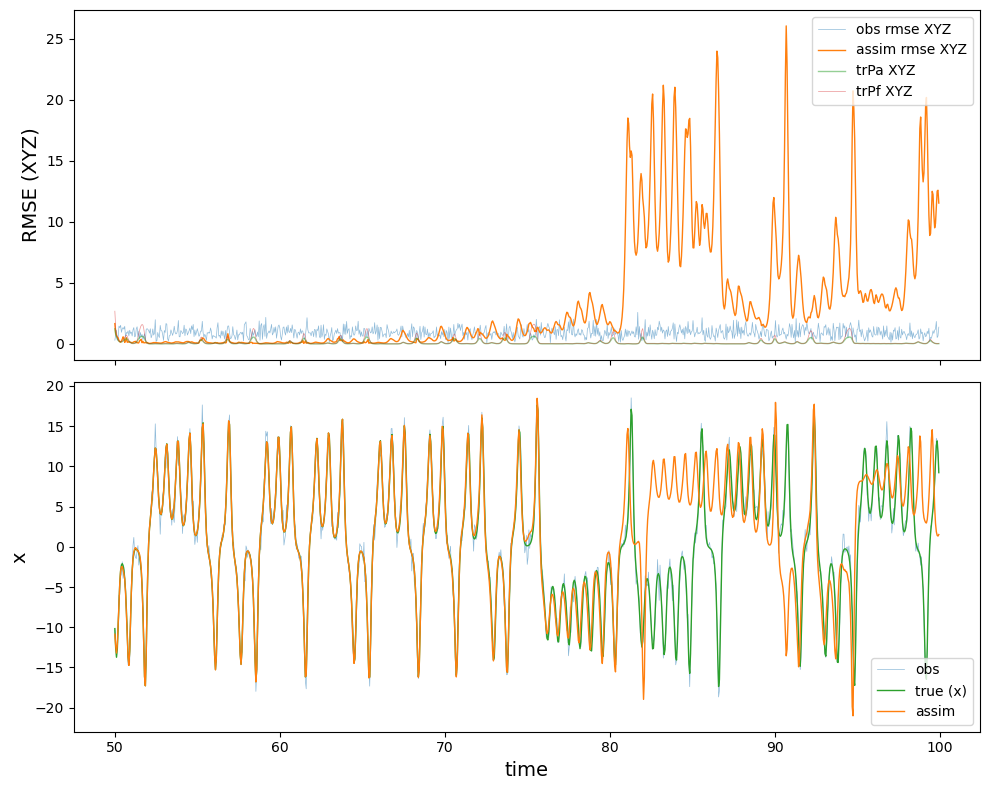

In [15]:
Xa0 = Y[0, :].copy()
P0 = np.eye(6)
P0[3, 3] = P0[4, 4] = P0[5, 5] = 0
assim_X = [Xa0]
assim_Pa = [P0.copy()]
estim_Pf = [P0.copy()]

t_plot = []

for i, ti in enumerate(t_integration):
    M = np.zeros((6, 6))
    M[0:3, 0:3] = get_tlm_by_approx(assim_X[-1], ti, Model)[0:3, 0:3] # only for x, y, z
    Pf, nX, nPa = KalmanFilter(assim_X[-1], ti, Y[i, :], Model, M, H=np.eye(6), R=np.eye(6), Pa=assim_Pa[-1])
    estim_Pf.append(Pf)
    assim_X.append(nX)
    t_plot.append(ti)
    assim_Pa.append(nPa)

print(f"estim_Pf: {estim_Pf[-1]}")

plot_result_xyz(0, t_plot, t_integration, assim_X, assim_Pa, estim_Pf, Y, X_attractor)

plt.savefig("L63_xyz_result_x.png", dpi=300)
plt.show()

同化と非同化のスイッチングが起こっている。(covariance inflation を入れていないため)

### 続いて、sigma の推定

sigma の初期値は適当に 8 とする。

estim_Pf: [[ 0.20733269  0.09596142 -0.29325875 -0.11098471  0.          0.        ]
 [ 0.09596142  0.40600442  0.01450577  0.02358549  0.          0.        ]
 [-0.29325875  0.01450577  0.74735402  0.0635292   0.          0.        ]
 [-0.11098471  0.02358549  0.0635292   0.49428243  0.          0.        ]
 [ 0.          0.          0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.          0.          0.        ]]


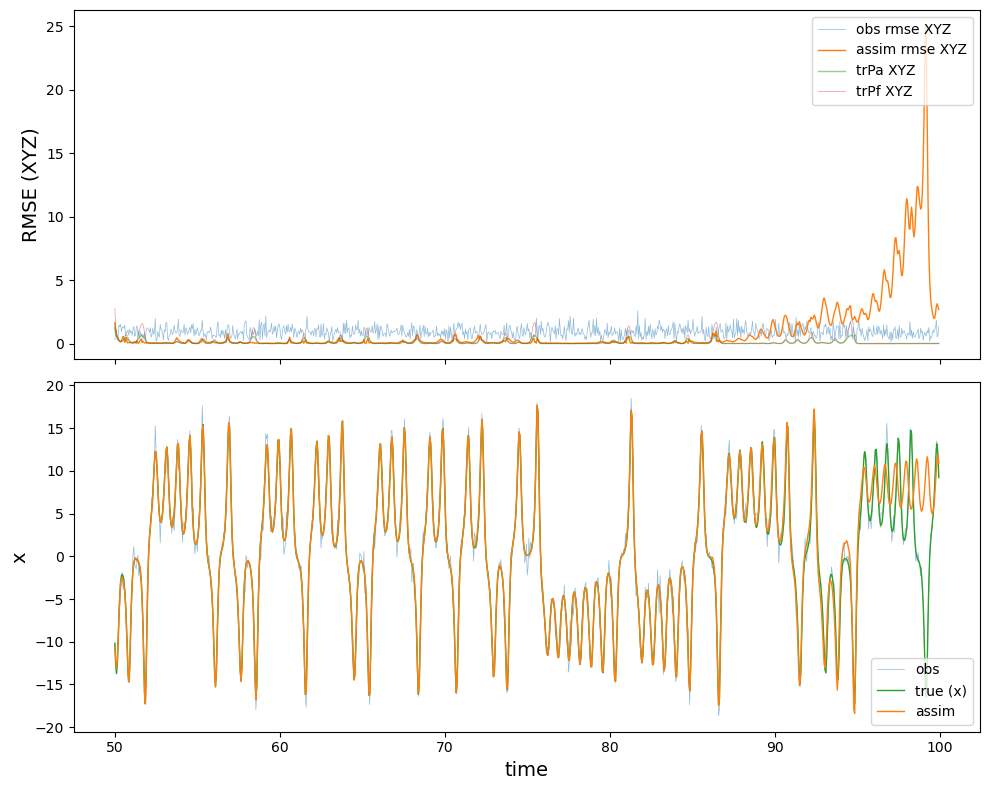

In [16]:
Xa0 = Y[0, :].copy()
Xa0[3] = 8.0

P0 = np.eye(6)
P0[4, 4] = P0[5, 5] = 0

assim_X = [Xa0]
assim_Pa = [P0.copy()]
estim_Pf = [P0.copy()]

t_plot = []

for i, ti in enumerate(t_integration):
    M = np.zeros((6, 6))
    M[0:4, 0:4] = get_tlm_by_approx(assim_X[-1], ti, Model)[0:4, 0:4] # only for x, y, z and sigma
    Pf, nX, nPa = KalmanFilter(assim_X[-1], ti, Y[i, :], Model, M, H=np.eye(6), R=np.eye(6), Pa=assim_Pa[-1])
    t_plot.append(ti)
    estim_Pf.append(Pf)
    assim_X.append(nX)
    assim_Pa.append(nPa)

print(f"estim_Pf: {estim_Pf[2]}")

plot_result_xyz(0, t_plot, t_integration, assim_X, assim_Pa, estim_Pf, Y, X_attractor)
plt.savefig("L63_xyzs_result_x.png", dpi=300)
plt.show()

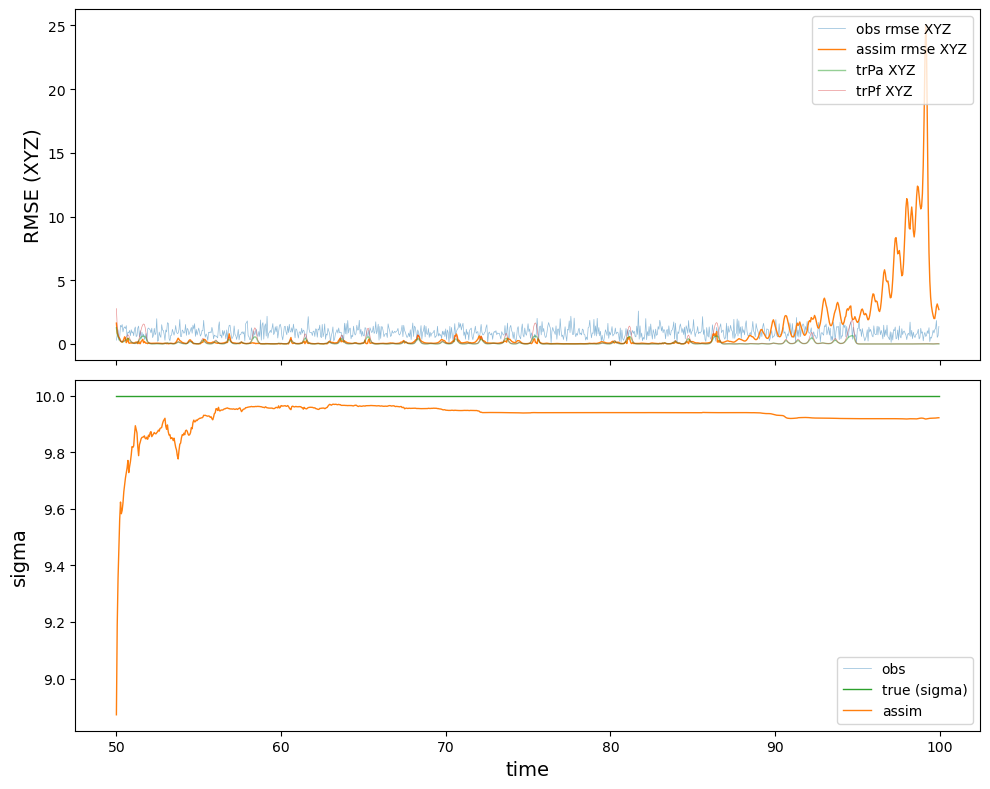

In [17]:
plot_result_xyz(3, t_plot, t_integration, assim_X, assim_Pa, estim_Pf, Y, X_attractor)
plt.savefig("L63_xyzs_result_s.png", dpi=300)
plt.show()

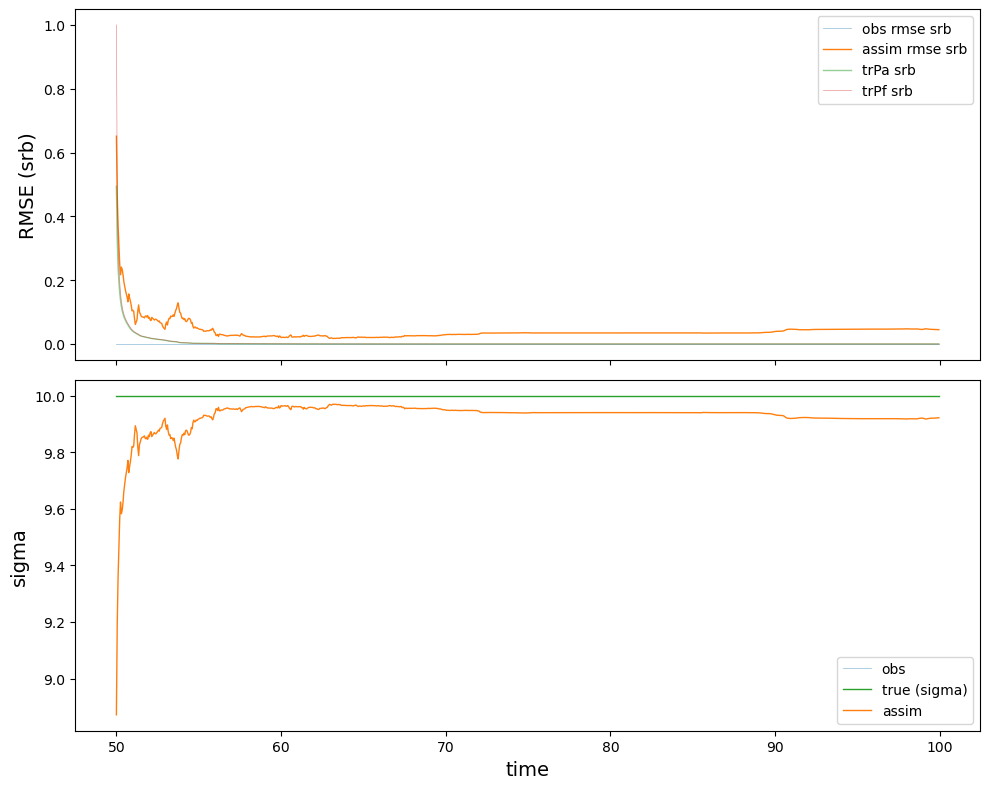

In [18]:
plot_result_srb(3, t_plot, t_integration, assim_X, assim_Pa, estim_Pf, Y, X_attractor)
plt.savefig("L63_xyzs_result_s_srb.png", dpi=300)
plt.show()

trueを中心に振動していないのはおかしい。これは同化に失敗している。

パラメータ空間でFilter Divergence が起こっていて、それがCovariance Inflationとして染み出して安定化している。


## Additive Inflation を入れてみる

estim_Pf: [[ 0.20781353  0.09592009 -0.29346581 -0.11408582  0.          0.        ]
 [ 0.09592009  0.40600797  0.01452357  0.02385202  0.          0.        ]
 [-0.29346581  0.01452357  0.74744318  0.06486457  0.          0.        ]
 [-0.11408582  0.02385202  0.06486457  0.51428243  0.          0.        ]
 [ 0.          0.          0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.          0.          0.        ]]


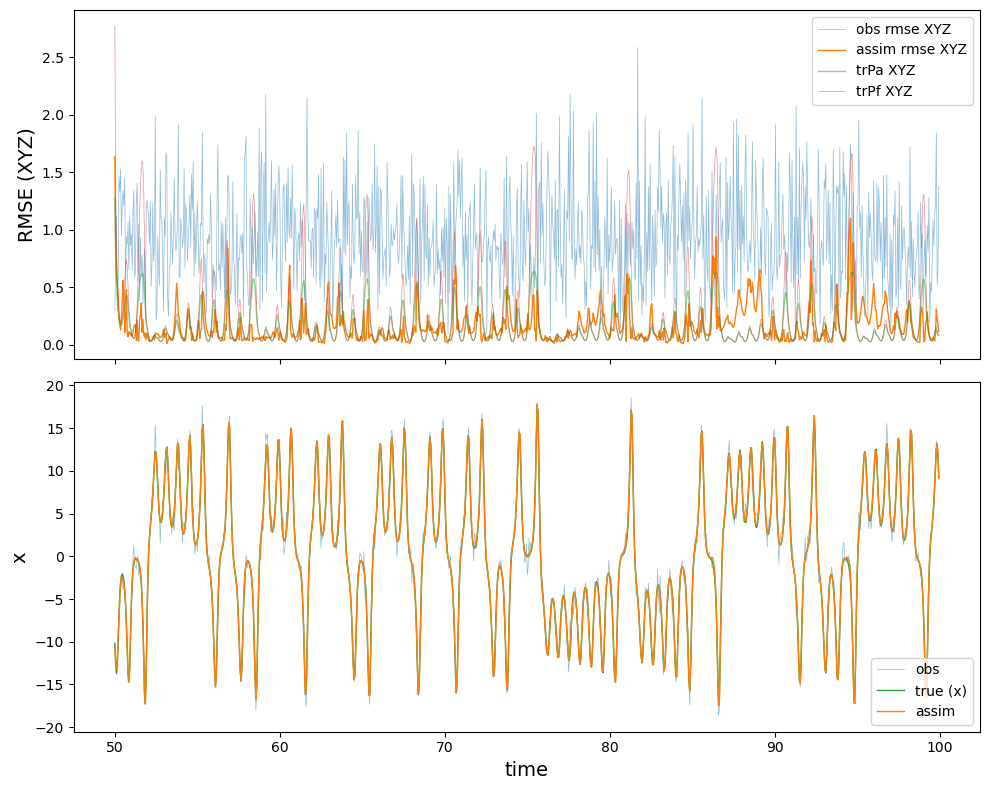

In [19]:
Xa0 = Y[0, :].copy()
Xa0[3] = 8.0

P0 = np.eye(6)
P0[4, 4] = P0[5, 5] = 0

assim_X = [Xa0]
assim_Pa = [P0.copy()]
estim_Pf = [P0.copy()]

t_plot = []

a_xyz = 0.0
a_s = 0.02

P_add = np.array([[a_xyz, 0,     0,     0,   0,   0  ], 
                  [0,     a_xyz, 0,     0,   0,   0  ],
                  [0,     0,     a_xyz, 0,   0,   0  ],
                  [0,     0,     0,     a_s, 0,   0  ],
                  [0,     0,     0,     0,   0,   0  ],
                  [0,     0,     0,     0,   0,   0  ]])

t_plot = []

for i, ti in enumerate(t_integration):
    M = np.zeros((6, 6))
    M[0:4, 0:4] = get_tlm_by_approx(assim_X[-1], ti, Model)[0:4, 0:4] # only for x, y, z and sigma
    Pf, nX, nPa = KalmanFilter(assim_X[-1], ti, Y[i, :], Model, M, H=np.eye(6), R=np.eye(6), Pa=assim_Pa[-1])
    t_plot.append(ti)
    estim_Pf.append(Pf)
    assim_X.append(nX)
    assim_Pa.append(nPa)

    nPa = nPa + P_add
    t_plot.append(ti)
    assim_Pa.append(nPa)

print(f"estim_Pf: {estim_Pf[2]}")

plot_result_xyz(0, t_plot, t_integration, assim_X, assim_Pa, estim_Pf, Y, X_attractor)
plt.savefig("L63_xyzs_inf_result_x.png", dpi=300)
plt.show()

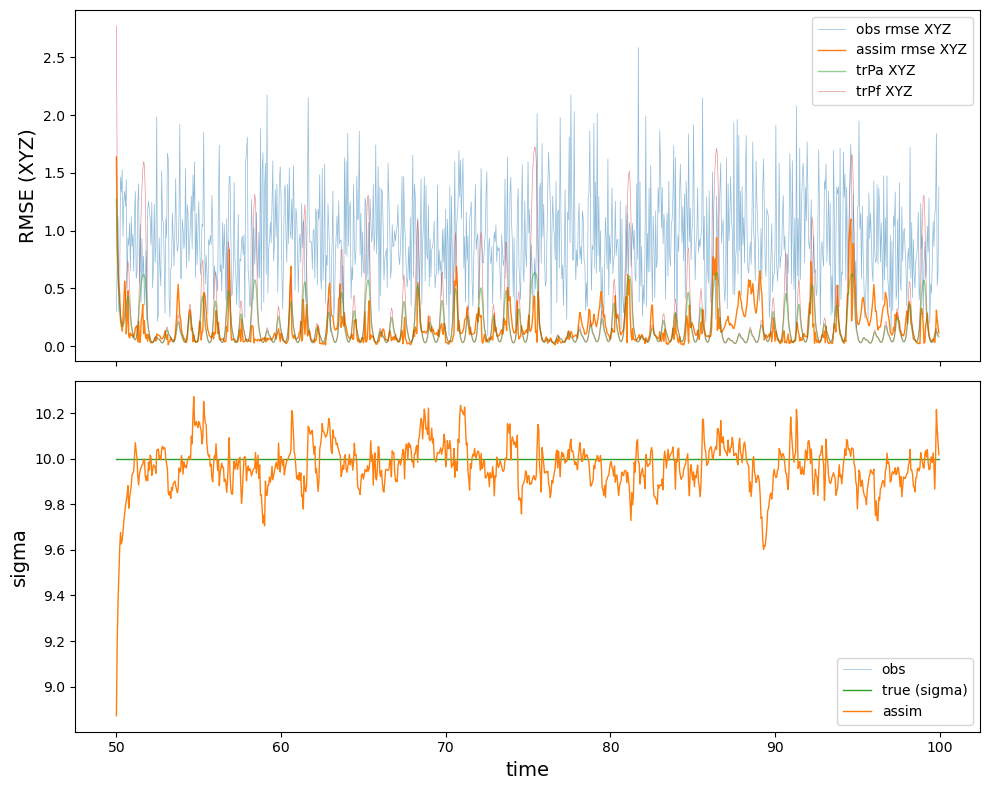

In [20]:
plot_result_xyz(3, t_plot, t_integration, assim_X, assim_Pa, estim_Pf, Y, X_attractor)
plt.savefig("L63_xyzs_inf_result_s.png", dpi=300)
plt.show()

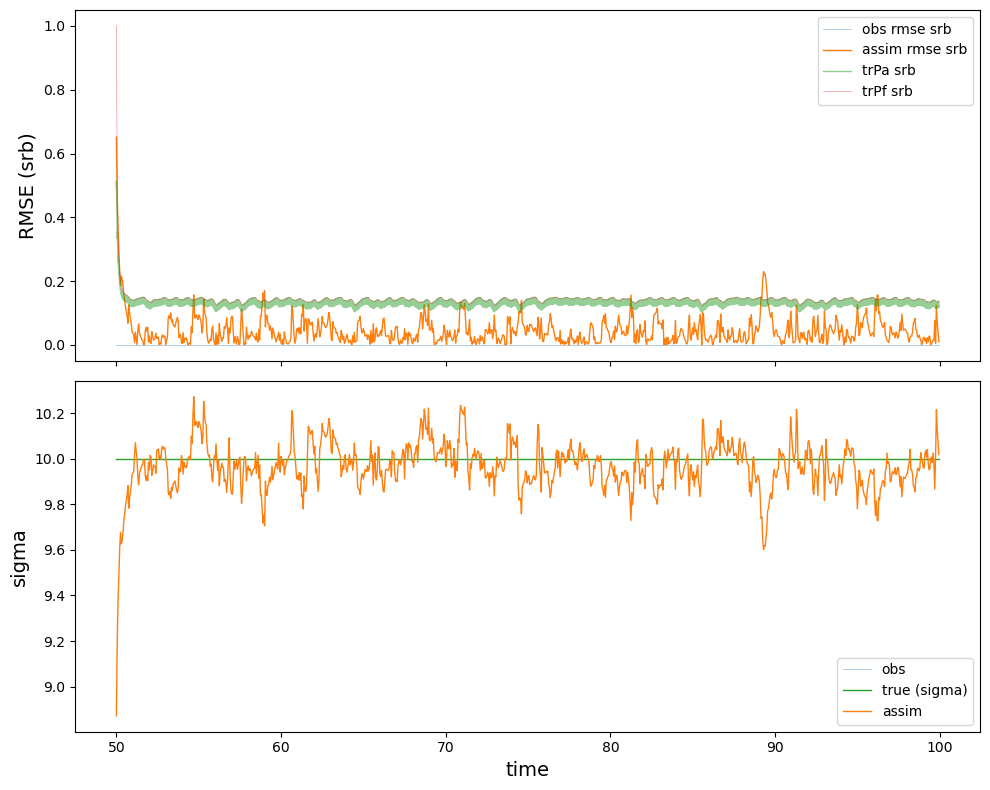

In [21]:
plot_result_srb(3, t_plot, t_integration, assim_X, assim_Pa, estim_Pf, Y, X_attractor)
plt.savefig("L63_xyzs_inf_result_s_srb.png", dpi=300)
plt.show()

## 最適な Inflation Parameter を探索する

In [22]:
def store_result(assim_X, X_attractor):
    rmses_xyz, rmses_s = [], []

    tn = X_attractor.shape[0]
    for i in range(tn):
        rmses_xyz.append(np.sqrt(np.mean((assim_X[i+1][0:3] - X_attractor[i, :][0:3])**2)))
        rmses_s  .append(np.sqrt(np.mean((assim_X[i+1][3]   - X_attractor[i, :][3]  )**2)))
    
    rmses_xyz, rmses_s = np.array(rmses_xyz), np.array(rmses_s)

    return np.mean(rmses_xyz), np.mean(rmses_s)

estim_Pf: [[ 0.20757311  0.09594076 -0.29336228 -0.11253526  0.          0.        ]
 [ 0.09594076  0.4060062   0.01451467  0.02371875  0.          0.        ]
 [-0.29336228  0.01451467  0.7473986   0.06419688  0.          0.        ]
 [-0.11253526  0.02371875  0.06419688  0.50428243  0.          0.        ]
 [ 0.          0.          0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.          0.          0.        ]]
0.1626782220406738 0.0792877497894002


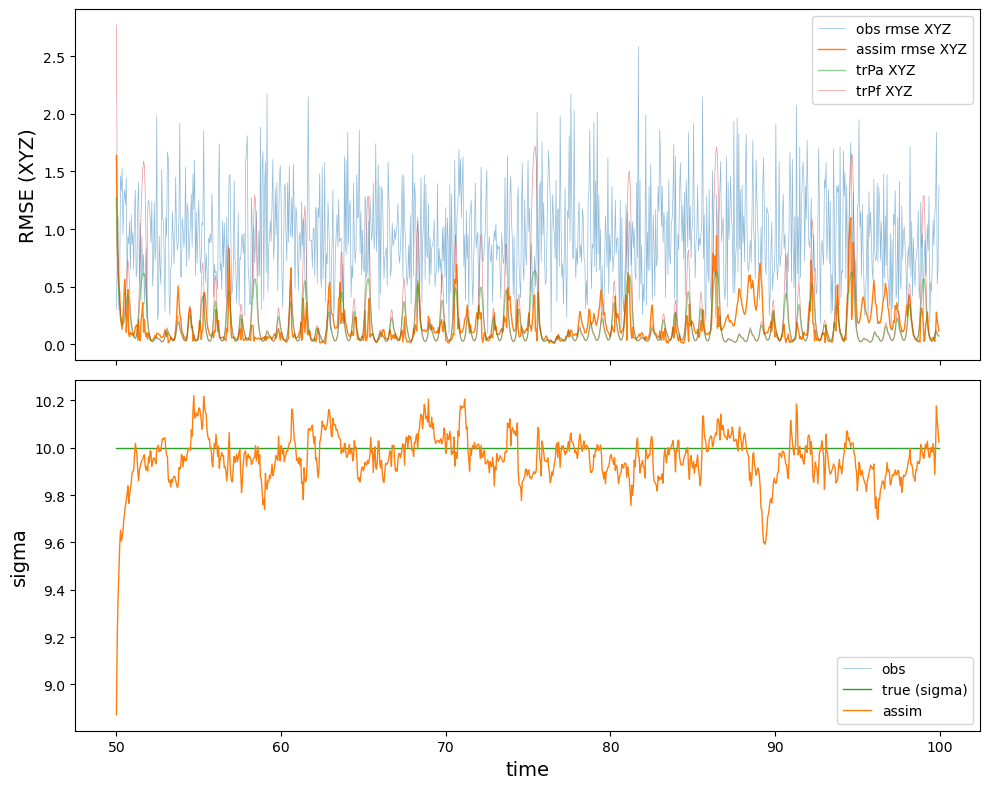

In [23]:
Xa0 = Y[0, :].copy()
Xa0[3] = 8.0

P0 = np.eye(6)
P0[4, 4] = P0[5, 5] = 0

assim_X = [Xa0]
assim_Pa = [P0.copy()]
estim_Pf = [P0.copy()]

t_plot = []

a_xyz = 0.0
a_s = 0.01

P_add = np.array([[a_xyz, 0,     0,     0,   0,   0  ], 
                  [0,     a_xyz, 0,     0,   0,   0  ],
                  [0,     0,     a_xyz, 0,   0,   0  ],
                  [0,     0,     0,     a_s, 0,   0  ],
                  [0,     0,     0,     0,   0,   0  ],
                  [0,     0,     0,     0,   0,   0  ]])

t_plot = []

for i, ti in enumerate(t_integration):
    M = np.zeros((6, 6))
    M[0:4, 0:4] = get_tlm_by_approx(assim_X[-1], ti, Model)[0:4, 0:4] # only for x, y, z and sigma
    Pf, nX, nPa = KalmanFilter(assim_X[-1], ti, Y[i, :], Model, M, H=np.eye(6), R=np.eye(6), Pa=assim_Pa[-1])
    t_plot.append(ti)
    estim_Pf.append(Pf)
    assim_X.append(nX)
    assim_Pa.append(nPa)

    nPa = nPa + P_add
    t_plot.append(ti)
    assim_Pa.append(nPa)

print(f"estim_Pf: {estim_Pf[2]}")

rmse_xyz, rmse_s = store_result(assim_X, X_attractor)

print(rmse_xyz, rmse_s)

plot_result_xyz(3, t_plot, t_integration, assim_X, assim_Pa, estim_Pf, Y, X_attractor)

In [24]:
xyz_list = np.arange(0.00, 1.0, 0.02)
s_list   = np.arange(0.00, 0.51, 0.01)
grid_size = (len(xyz_list), len(s_list))

RMSE_xyz, RMSE_s = np.zeros(grid_size), np.zeros(grid_size)


Xa0 = Y[0, :].copy()
Xa0[3] = 8.0

P0 = np.eye(6)
P0[4, 4] = P0[5, 5] = 0


for ai, a_xyz in enumerate(xyz_list):
    print("a_xyz =", a_xyz)
    for aj, a_s in enumerate(s_list):
        # print(a_s)
        
        assim_X = [Xa0]
        assim_Pa = [P0.copy()]
        estim_Pf = [P0.copy()]

        t_plot = []

        P_add = np.array([[a_xyz, 0,     0,     0,   0,   0  ], 
                          [0,     a_xyz, 0,     0,   0,   0  ],
                          [0,     0,     a_xyz, 0,   0,   0  ],
                          [0,     0,     0,     a_s, 0,   0  ],
                          [0,     0,     0,     0,   0,   0  ],
                          [0,     0,     0,     0,   0,   0  ]])

        t_plot = []

        for i, ti in enumerate(t_integration):
            M = np.zeros((6, 6))
            M[0:4, 0:4] = get_tlm_by_approx(assim_X[-1], ti, Model)[0:4, 0:4] # only for x, y, z and sigma
            Pf, nX, nPa = KalmanFilter(assim_X[-1], ti, Y[i, :], Model, M, H=np.eye(6), R=np.eye(6), Pa=assim_Pa[-1])
            t_plot.append(ti)
            estim_Pf.append(Pf)
            assim_X.append(nX)
            assim_Pa.append(nPa)

            nPa = nPa + P_add
            t_plot.append(ti)
            assim_Pa.append(nPa)


        RMSE_xyz[ai, aj], RMSE_s[ai, aj] = store_result(assim_X, X_attractor)

a_xyz = 0.0
a_xyz = 0.02
a_xyz = 0.04
a_xyz = 0.06
a_xyz = 0.08
a_xyz = 0.1
a_xyz = 0.12
a_xyz = 0.14
a_xyz = 0.16
a_xyz = 0.18
a_xyz = 0.2
a_xyz = 0.22
a_xyz = 0.24
a_xyz = 0.26
a_xyz = 0.28
a_xyz = 0.3
a_xyz = 0.32
a_xyz = 0.34
a_xyz = 0.36
a_xyz = 0.38
a_xyz = 0.4
a_xyz = 0.42
a_xyz = 0.44
a_xyz = 0.46
a_xyz = 0.48
a_xyz = 0.5
a_xyz = 0.52
a_xyz = 0.54
a_xyz = 0.56
a_xyz = 0.58
a_xyz = 0.6
a_xyz = 0.62
a_xyz = 0.64
a_xyz = 0.66
a_xyz = 0.68
a_xyz = 0.7000000000000001
a_xyz = 0.72
a_xyz = 0.74
a_xyz = 0.76
a_xyz = 0.78
a_xyz = 0.8
a_xyz = 0.8200000000000001
a_xyz = 0.84
a_xyz = 0.86
a_xyz = 0.88
a_xyz = 0.9
a_xyz = 0.92
a_xyz = 0.9400000000000001
a_xyz = 0.96
a_xyz = 0.98


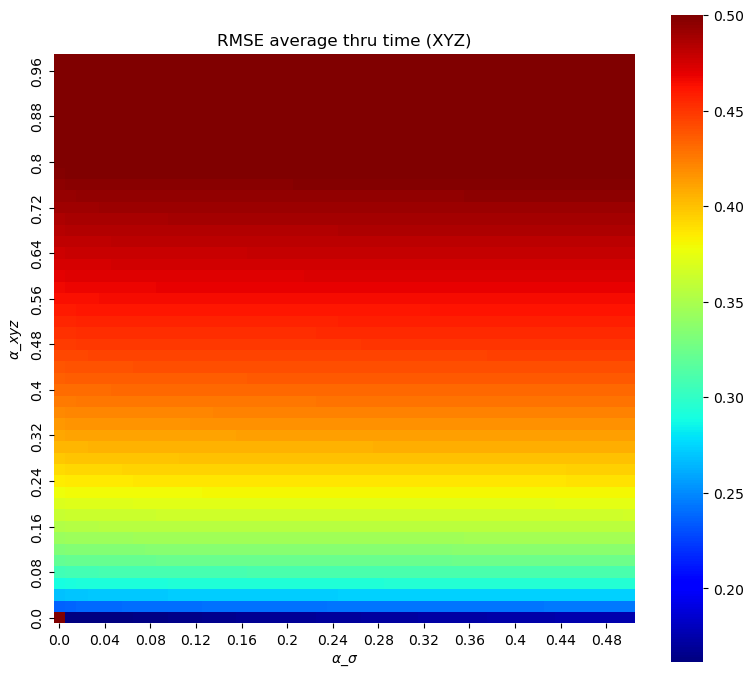

In [25]:
fig, ax = plt.subplots(1, 1, figsize=(8, 7))

sns.heatmap(RMSE_xyz, cmap="jet",
            vmax=0.50,
            square=True, ax=ax,
            )

xticks, yticks = ax.get_xticks(), ax.get_yticks()

ax.set_xlabel(r"$\alpha$_$\sigma$")
ax.set_xticks(xticks[::2], s_list[::4])

ax.set_ylabel(r"$\alpha$_$xyz$")
ax.set_yticks(yticks[::2], xyz_list[::4])
ax.invert_yaxis()

ax.set_title("RMSE average thru time (XYZ)")

plt.tight_layout()
plt.savefig("alpha_heatmap_xyz.png")
plt.show()

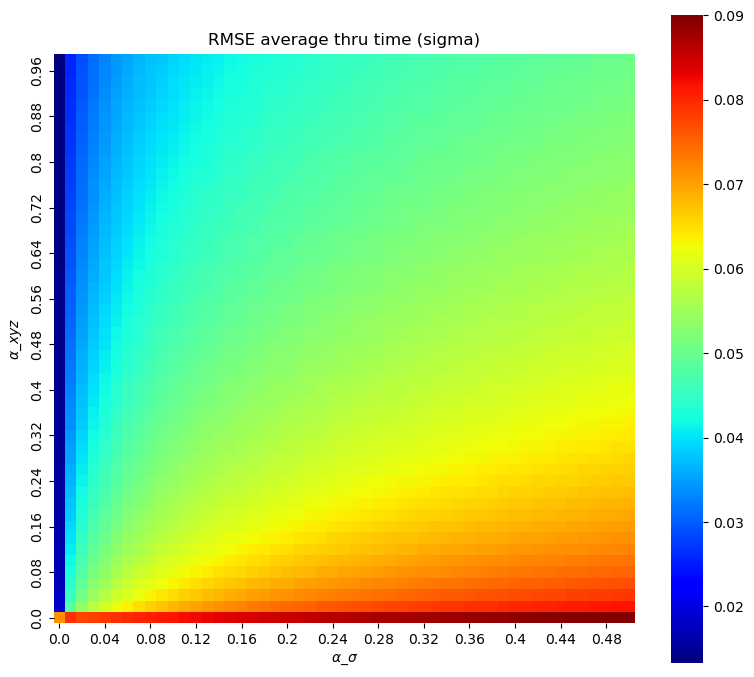

In [26]:
fig, ax = plt.subplots(1, 1, figsize=(8, 7))

sns.heatmap(RMSE_s, cmap="jet",
            square=True, ax=ax,
            )

xticks, yticks = ax.get_xticks(), ax.get_yticks()

ax.set_xlabel(r"$\alpha$_$\sigma$")
ax.set_xticks(xticks[::2], s_list[::4])

ax.set_ylabel(r"$\alpha$_$xyz$")
ax.set_yticks(yticks[::2], xyz_list[::4])
ax.invert_yaxis()

ax.set_title("RMSE average thru time (sigma)")

plt.tight_layout()
plt.savefig("alpha_heatmap_sigma.png")
plt.show()